In [17]:
pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 393.8 kB/s eta 0:05:18
   ---------------------------------------- 0.1/124.9 MB 901.1 kB/s eta 0:02:19
   ---------------------------------------- 0.2/124.9 MB 1.3 MB/s eta 0:01:35
   ---------------------------------------- 0.4/124.9 MB 1.6 MB/s eta 0:01:18
   ---------------------------------------- 0.6/124.9 MB 2.2 MB/s eta 0:00:56
   ---------------------------------------- 0.9/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 0.9/124.9 MB 3.0 MB/s eta 0:00:42
   ---------------------------------------- 0.9/124.9 MB 3.0 MB/s eta 0:00:42
    --------------------------------------- 1.7/124.9 MB 3.9 MB/s eta 0:00:32
    --------------------------------------- 2.8/124.9 MB 5.7 MB/s eta 0:00:22
   - -------------------------------------- 3.3/124.9 MB 6.0 MB/s eta 0:00

In [24]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [25]:
FPT = pd.read_csv("FPT.csv")
MSN = pd.read_csv("MSN.csv")
PNJ = pd.read_csv("PNJ.csv")
VIC = pd.read_csv("VIC.csv")

In [56]:
FPT.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [57]:
MSN.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [58]:
PNJ.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [59]:
VIC.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [60]:
FPT['Open Interest'].value_counts()

Open Interest
0    97406
Name: count, dtype: int64

In [61]:
MSN['Open Interest'].value_counts()

Open Interest
0    135354
Name: count, dtype: int64

In [62]:
PNJ['Open Interest'].value_counts()

Open Interest
0    125309
Name: count, dtype: int64

In [63]:
VIC['Open Interest'].value_counts()

Open Interest
0    101266
Name: count, dtype: int64

In [26]:
df_FPT = FPT.copy()
df_MSN = MSN.copy()
df_PNJ = PNJ.copy()
df_VIC = VIC.copy()

In [67]:
def draw_plot(df):
    plt.figure(figsize=(16,6))
    plt.title('Close Price History')
    plt.plot(df['Date/Time'] ,df['Close'])
    plt.xlabel('Date/Time', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.show()

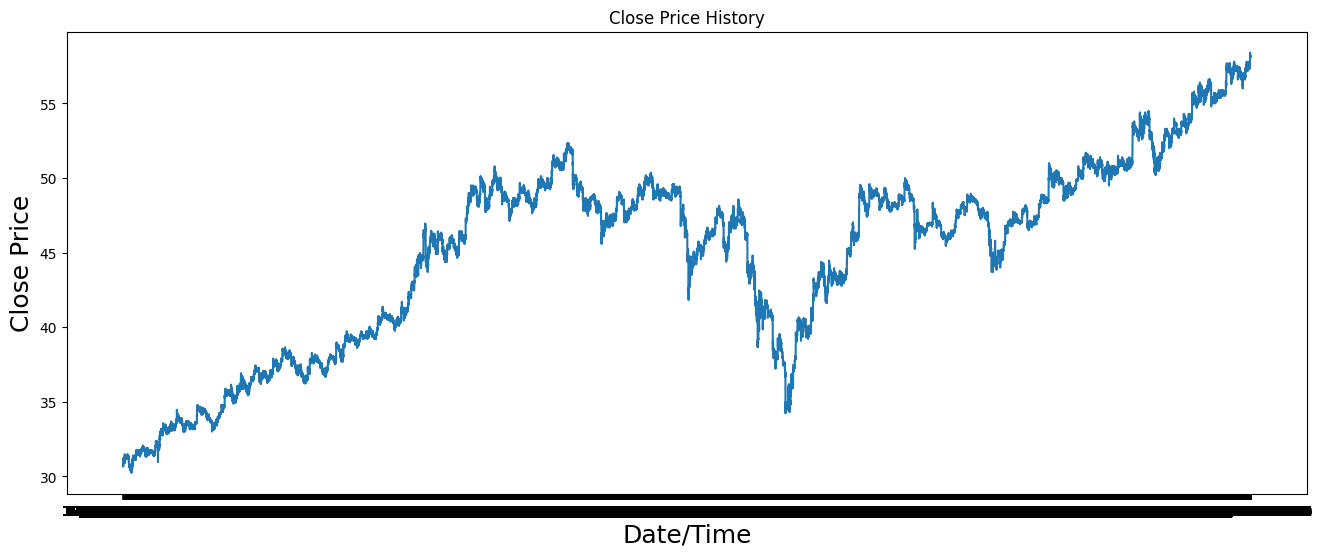

In [68]:
FPT_plot = draw_plot(FPT)

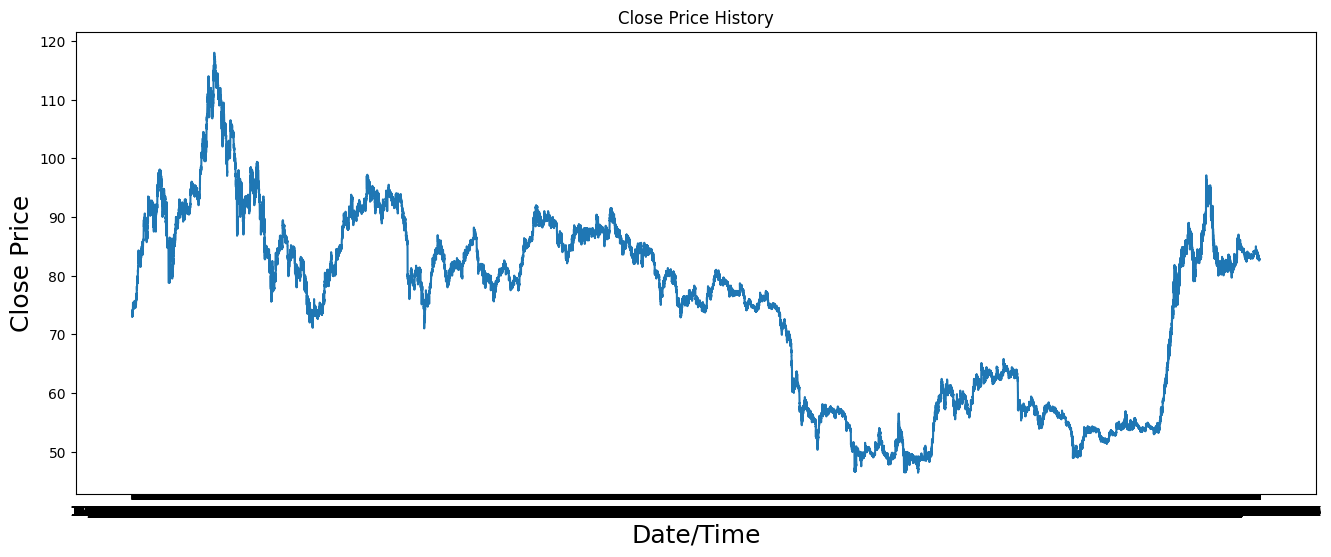

In [69]:
MSN_plot = draw_plot(MSN)

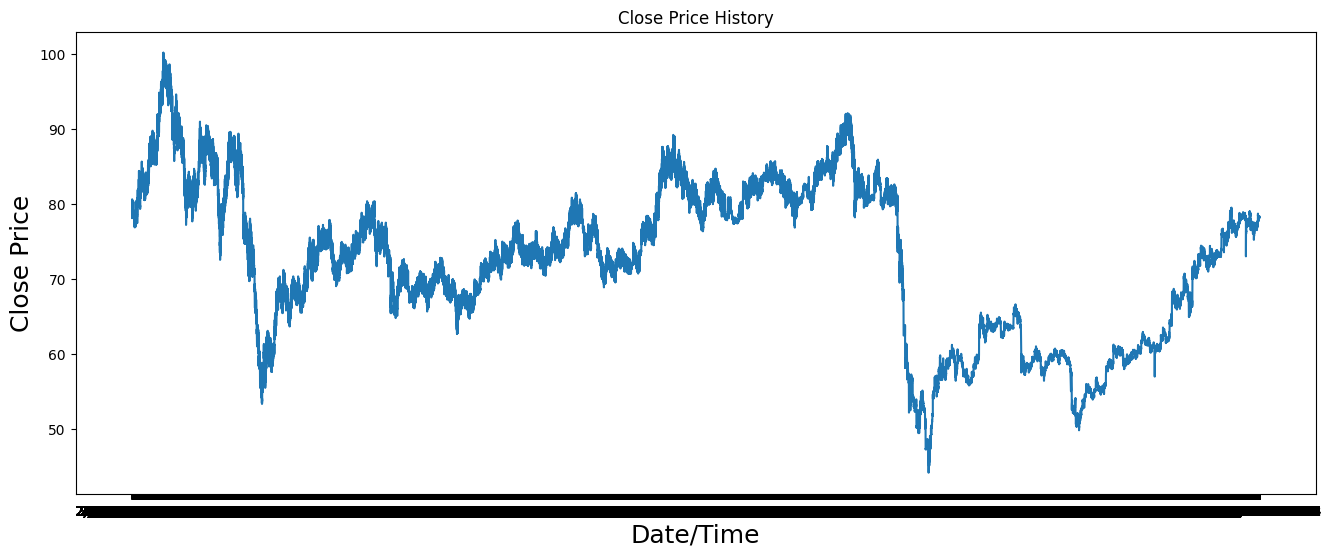

In [70]:
PNJ_plot = draw_plot(PNJ)

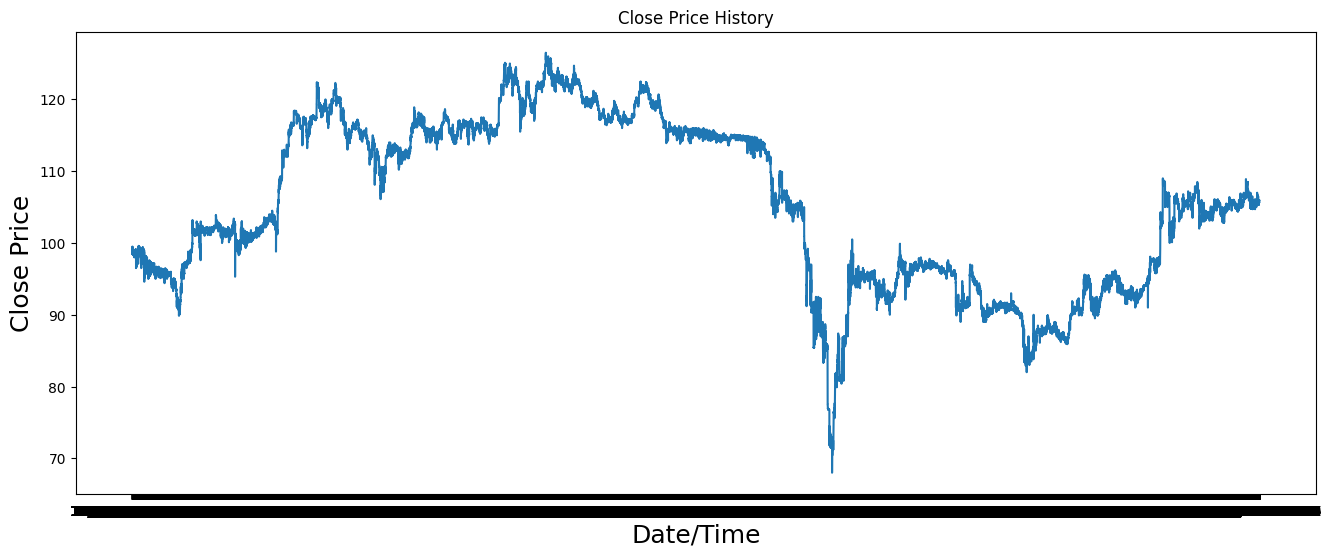

In [71]:
VIC_plot = draw_plot(VIC)

In [27]:
def prepare_data(df, column_name='Close', percent=0.75, step_times=3360):
    data_target = df.filter([column_name])
    target = data_target.values

    # Chia dữ liệu
    training_data_len = math.ceil(len(target) * percent)

    # Chuẩn hóa về khoảng giá trị (0,1)
    sc = MinMaxScaler(feature_range=(0, 1))
    training_scaled_data = sc.fit_transform(target)
    

    train_data = training_scaled_data[0:training_data_len, :]
    X_train = []
    y_train = []
    for i in range(step_times, len(train_data)):
        X_train.append(train_data[i-step_times:i, 0])
        y_train.append(train_data[i, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    

    test_data = training_scaled_data[training_data_len - step_times:, :]
    X_test = []
    for i in range(step_times, len(test_data)):
        X_test.append(test_data[i-step_times:i, 0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    y_test = target[training_data_len:, :]
    
    return X_train, y_train, X_test, y_test, sc, training_data_len, data_target

In [28]:
def build_and_train_lstm(X_train, y_train, step_times=3360, epochs=1, batch_size=32):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(step_times, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    return model

In [29]:
def set_datetime_index(df, datetime_column='Date/Time'):
    df[datetime_column] = pd.to_datetime(df[datetime_column])
    df.set_index(datetime_column, inplace=True)
    return df

In [30]:
df_FPT = set_datetime_index(df_FPT)
df_MSN = set_datetime_index(df_MSN)
df_PNJ = set_datetime_index(df_PNJ)
df_VIC = set_datetime_index(df_VIC)

In [31]:
def predict_and_plot(model, X_test, y_test, scaler, training_data_len, data_target):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    
    train = data_target[:training_data_len]
    valid = data_target[training_data_len:]
    valid['Predictions'] = predictions
    
    mse = mean_squared_error(valid['Close'], valid['Predictions'])
    print(f"Mean Squared Error: {mse}")

    plt.figure(figsize=(10, 5))
    plt.title('Model')
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Close Price', fontsize=12)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

    return valid

In [32]:
X_train_FPT, y_train_FPT, X_test_FPT, y_test_FPT, scaler_FPT, training_data_len_FPT, data_target_FPT = prepare_data(df_FPT, step_times=960)

In [33]:
X_train_PNJ, y_train_PNJ, X_test_PNJ, y_test_PNJ, scaler_PNJ, training_data_len_PNJ, data_target_PNJ = prepare_data(df_PNJ, step_times=960)

In [34]:
X_train_MSN, y_train_MSN, X_test_MSN, y_test_MSN, scaler_MSN, training_data_len_MSN, data_target_MSN = prepare_data(df_MSN, step_times=960)

In [35]:
X_train_VIC, y_train_VIC, X_test_VIC, y_test_VIC, scaler_VIC, training_data_len_VIC, data_target_VIC = prepare_data(df_VIC, step_times=960)

In [36]:
# Xây dựng và huấn luyện mô hình
model_FPT = build_and_train_lstm(X_train_FPT, y_train_FPT)

D:\Anaconda\envs\Finpros\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 764s 338ms/step - loss: 0.0032 - mean_absolute_error: 0.0150


In [37]:
model_PNJ = build_and_train_lstm(X_train_PNJ, y_train_PNJ)


2907/2907 ━━━━━━━━━━━━━━━━━━━━ 1050s 361ms/step - loss: 0.0039 - mean_absolute_error: 0.0205


In [38]:
model_MSN = build_and_train_lstm(X_train_MSN, y_train_MSN)

3143/3143 ━━━━━━━━━━━━━━━━━━━━ 1180s 375ms/step - loss: 0.0021 - mean_absolute_error: 0.0118


In [39]:
model_VIC = build_and_train_lstm(X_train_VIC, y_train_VIC)

2344/2344 ━━━━━━━━━━━━━━━━━━━━ 859s 365ms/step - loss: 0.0070 - mean_absolute_error: 0.0227


761/761 ━━━━━━━━━━━━━━━━━━━━ 84s 110ms/step


C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\3053387867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


Mean Squared Error: 0.052020632353484995


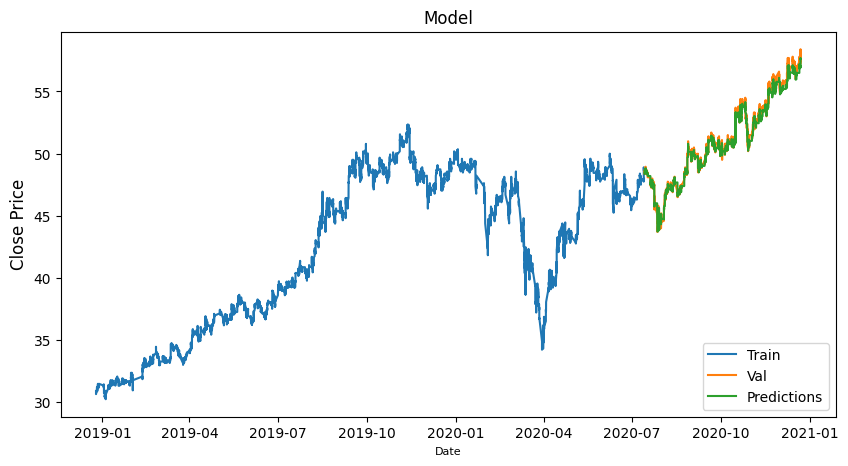

In [41]:
valid_FPT = predict_and_plot(model_FPT, X_test_FPT, y_test_FPT, scaler_FPT, training_data_len_FPT, data_target_FPT)




1058/1058 ━━━━━━━━━━━━━━━━━━━━ 116s 110ms/step
Mean Squared Error: 0.2629663974616095


C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\3053387867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


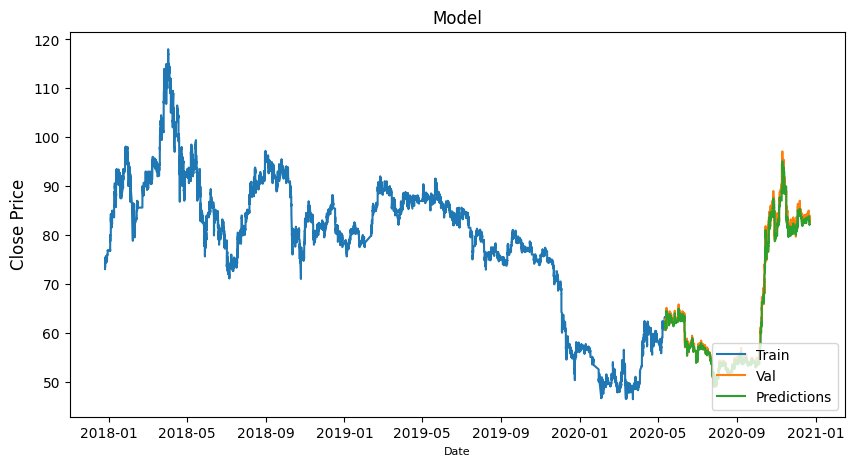

In [42]:
valid_MSN = predict_and_plot(model_MSN, X_test_MSN, y_test_MSN, scaler_MSN, training_data_len_MSN, data_target_MSN)

979/979 ━━━━━━━━━━━━━━━━━━━━ 104s 106ms/step


C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\3053387867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


Mean Squared Error: 0.13303780266101714


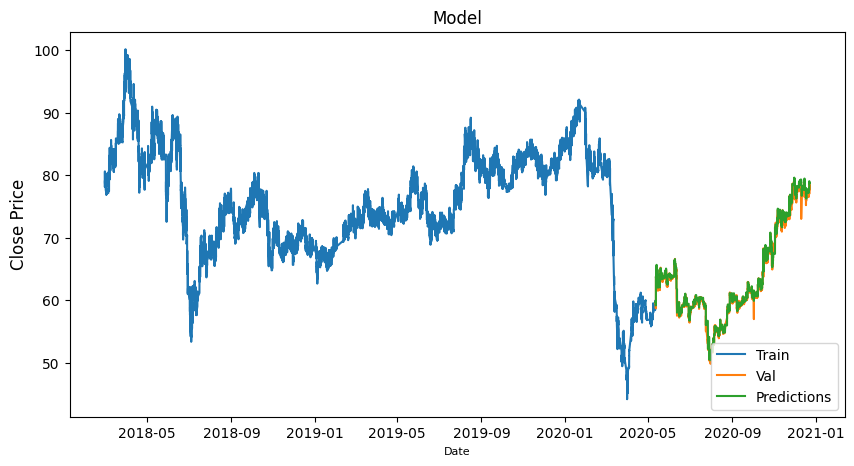

In [43]:
valid_PNJ = predict_and_plot(model_PNJ, X_test_PNJ, y_test_PNJ, scaler_PNJ, training_data_len_PNJ, data_target_PNJ)

792/792 ━━━━━━━━━━━━━━━━━━━━ 84s 106ms/step
Mean Squared Error: 0.13575870071189966


C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\3053387867.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


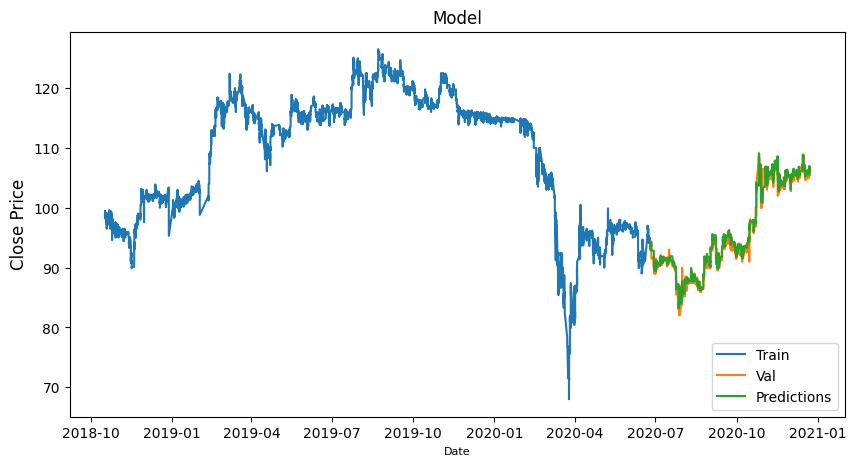

In [44]:
valid_VIC = predict_and_plot(model_VIC, X_test_VIC, y_test_VIC, scaler_VIC, training_data_len_VIC, data_target_VIC)

In [45]:
valid_FPT


,Close,Predictions
Date/Time,,
2020-07-14 09:56:00,48.65,48.609425
2020-07-14 09:57:00,48.65,48.608135
2020-07-14 09:58:00,48.60,48.607708
2020-07-14 09:59:00,48.60,48.606094
2020-07-14 10:00:00,48.65,48.603622
...,...,...
2020-12-22 14:24:00,58.20,57.620720
2020-12-22 14:25:00,58.20,57.619476
2020-12-22 14:26:00,58.20,57.620605


In [46]:
valid_MSN

,Close,Predictions
Date/Time,,
2020-05-12 13:22:00,62.6,62.067585
2020-05-12 13:23:00,62.7,62.086304
2020-05-12 13:24:00,62.7,62.109859
2020-05-12 13:25:00,62.7,62.135700
2020-05-12 13:26:00,62.7,62.161976
...,...,...
2020-12-22 14:23:00,82.8,82.113945
2020-12-22 14:24:00,82.8,82.122398
2020-12-22 14:25:00,82.8,82.130722


In [47]:
valid_PNJ

,Close,Predictions
Date/Time,,
2020-05-11 14:23:00,59.5,59.699135
2020-05-11 14:24:00,59.5,59.690922
2020-05-11 14:25:00,59.6,59.683422
2020-05-11 14:26:00,59.7,59.680183
2020-05-11 14:27:00,59.7,59.683830
...,...,...
2020-12-22 14:22:00,78.2,78.782852
2020-12-22 14:23:00,78.2,78.785133
2020-12-22 14:24:00,78.2,78.785805


In [48]:
valid_VIC

,Close,Predictions
Date/Time,,
2020-06-25 10:30:00,93.6,93.675880
2020-06-25 10:31:00,93.5,93.675102
2020-06-25 10:32:00,93.6,93.672607
2020-06-25 10:33:00,93.6,93.672829
2020-06-25 10:34:00,93.5,93.674927
...,...,...
2020-12-22 14:22:00,105.7,106.214584
2020-12-22 14:23:00,105.7,106.199821
2020-12-22 14:24:00,105.7,106.183578


In [63]:
future_df

,Date/Time,Predicted Close
0,2020-07-14 09:56:00,48.807320
1,2020-07-14 09:57:00,48.811584
2,2020-07-14 09:58:00,48.820969
3,2020-07-14 09:59:00,48.833961
4,2020-07-14 10:00:00,48.849491
...,...,...
115,2020-07-14 11:51:00,50.960449
116,2020-07-14 11:52:00,50.977051
117,2020-07-14 11:53:00,50.993610
118,2020-07-14 11:54:00,51.010120


In [49]:
def predict_for_company(X, df, model, scaler, training_data_len, step_times, n_minutes):
    # Lấy chuỗi giá trị cuối cùng từ X
    last_sequence = X[-1]  
    last_sequence = last_sequence.reshape(step_times, 1)
    
    future_predictions = []
    
    for _ in range(n_minutes):
        x_input = last_sequence.reshape(1, step_times, 1)
        prediction = model.predict(x_input)
        future_predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(step_times, 1)
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
    
    last_train_date = df.index[training_data_len - 1]
    future_dates = pd.date_range(start=last_train_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')
    future_df = pd.DataFrame({'Date/Time': future_dates, 'Predicted Close': future_predictions})
    future_df.set_index('Date/Time', inplace=True)
    return future_df

In [97]:
future_minutes = 120
future_predictions_FPT = predict_for_company(X_train_FPT, df_FPT, model_FPT, scaler_FPT, training_data_len_FPT, 960, future_minutes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

C:\Users\My PC\AppData\Local\Temp\ipykernel_1488\1215108609.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=last_train_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')


In [98]:
future_predictions_FPT

,Predicted Close
Date/Time,
2020-07-14 09:56:00,48.599754
2020-07-14 09:57:00,48.594566
2020-07-14 09:58:00,48.589344
2020-07-14 09:59:00,48.584064
2020-07-14 10:00:00,48.578716
...,...
2020-07-14 11:51:00,48.015854
2020-07-14 11:52:00,48.011307
2020-07-14 11:53:00,48.006760


In [50]:
def predict_price_change_for_company(X_test, df, model, scaler, step_times, n_minutes):
    # Lấy chuỗi giá trị cuối cùng từ tập dataset
    last_sequence = X_test[-1] 
    last_sequence = last_sequence.reshape(step_times, 1)
    
    future_predictions = []
    price_changes = []

    for _ in range(n_minutes):
        x_input = last_sequence.reshape(1, step_times, 1)
        prediction = model.predict(x_input)
        future_predictions.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction).reshape(step_times, 1)
    
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
    
    # Tính toán giá biến động
    current_price = scaler.inverse_transform(last_sequence[-1].reshape(-1, 1))[0, 0]
    for predicted_price in future_predictions:
        price_change = predicted_price - current_price
        price_changes.append(price_change)

    last_test_date = df.index[-1]
    future_dates = pd.date_range(start=last_test_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')
    future_df = pd.DataFrame({'Date/Time': future_dates, 'Predicted Close': future_predictions, 'Price Change': price_changes})
    future_df.set_index('Date/Time', inplace=True)
    return future_df

In [99]:
df_FPT['Close'].iloc[-1]

58.1

In [100]:
df_FPT.index[-1]

Timestamp('2020-12-22 14:46:00')

In [51]:
future_minutes = 120
future_price_change_predictions_FPT = predict_price_change_for_company(X_test_FPT, df_FPT, model_FPT, scaler_FPT, 960, future_minutes)
future_price_change_predictions_MSN = predict_price_change_for_company(X_test_MSN, df_MSN, model_MSN, scaler_MSN, 960, future_minutes)
future_price_change_predictions_PNJ = predict_price_change_for_company(X_test_PNJ, df_PNJ, model_PNJ, scaler_PNJ, 960, future_minutes)
future_price_change_predictions_VIC = predict_price_change_for_company(X_test_VIC, df_VIC, model_VIC, scaler_VIC, 960, future_minutes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━

C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\1809714473.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=last_test_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━

C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\1809714473.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=last_test_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\1809714473.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=last_test_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━

C:\Users\My PC\AppData\Local\Temp\ipykernel_8704\1809714473.py:24: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_dates = pd.date_range(start=last_test_date + pd.Timedelta(minutes=1), periods=n_minutes, freq='T')


In [72]:
#Từ phần tử cuối cùng trong tập train
future_predictions_VIC 

,Predicted Close
Date/Time,
2020-06-25 10:30:00,93.584106
2020-06-25 10:31:00,93.582718
2020-06-25 10:32:00,93.583023
2020-06-25 10:33:00,93.584534
2020-06-25 10:34:00,93.586906
...,...
2020-06-25 12:25:00,94.067879
2020-06-25 12:26:00,94.072357
2020-06-25 12:27:00,94.076859


In [73]:
#Từ phần tử cuối cùng trong tập train
future_predictions_PNJ 

,Predicted Close
Date/Time,
2020-05-11 14:23:00,60.012539
2020-05-11 14:24:00,60.026100
2020-05-11 14:25:00,60.054737
2020-05-11 14:26:00,60.094273
2020-05-11 14:27:00,60.141525
...,...
2020-05-11 16:18:00,68.025681
2020-05-11 16:19:00,68.109138
2020-05-11 16:20:00,68.192863


In [52]:
#Từ phần tử cuối cùng trong tập dataset
future_price_change_predictions_FPT

,Predicted Close,Price Change
Date/Time,,
2020-12-22 14:47:00,57.623707,4.303519
2020-12-22 14:48:00,57.606251,4.286063
2020-12-22 14:49:00,57.575840,4.255652
2020-12-22 14:50:00,57.536308,4.216121
2020-12-22 14:51:00,57.490543,4.170356
...,...,...
2020-12-22 16:42:00,53.411892,0.091704
2020-12-22 16:43:00,53.388748,0.068561
2020-12-22 16:44:00,53.365749,0.045562


In [53]:
#Từ phần tử cuối cùng trong tập dataset
future_price_change_predictions_MSN

,Predicted Close,Price Change
Date/Time,,
2020-12-22 14:47:00,82.145584,9.389303
2020-12-22 14:48:00,82.119484,9.363203
2020-12-22 14:49:00,82.072037,9.315755
2020-12-22 14:50:00,82.009857,9.253576
2020-12-22 14:51:00,81.937729,9.181448
...,...,...
2020-12-22 16:42:00,73.041389,0.285108
2020-12-22 16:43:00,72.969894,0.213613
2020-12-22 16:44:00,72.898544,0.142263


In [54]:
#So với phần tử cuối cùng trong tập dataset
future_price_change_predictions_PNJ

,Predicted Close,Price Change
Date/Time,,
2020-12-22 14:47:00,78.779587,-1.006509e+01
2020-12-22 14:48:00,78.797592,-1.004708e+01
2020-12-22 14:49:00,78.832191,-1.001248e+01
2020-12-22 14:50:00,78.879585,-9.965088e+00
2020-12-22 14:51:00,78.936432,-9.908241e+00
...,...,...
2020-12-22 16:42:00,88.472740,-3.719332e-01
2020-12-22 16:43:00,88.565674,-2.789995e-01
2020-12-22 16:44:00,88.658638,-1.860353e-01


In [55]:
#So với phần tử cuối cùng trong tập dataset
future_price_change_predictions_VIC

,Predicted Close,Price Change
Date/Time,,
2020-12-22 14:47:00,106.150528,-5.593802
2020-12-22 14:48:00,106.152756,-5.591574
2020-12-22 14:49:00,106.167786,-5.576544
2020-12-22 14:50:00,106.191971,-5.552359
2020-12-22 14:51:00,106.222618,-5.521711
...,...,...
2020-12-22 16:42:00,111.534462,-0.209868
2020-12-22 16:43:00,111.586830,-0.157499
2020-12-22 16:44:00,111.639275,-0.105055


In [115]:
def prepare_data_arima(df, column_name='Close', percent=0.75):
    """
    Chuẩn bị dữ liệu cho mô hình ARIMA.
    """
    data_target = df.filter([column_name])
    target = data_target.values

    training_data_len = int(np.ceil(len(target) * percent))

    train, test = df[:training_data_len], df[training_data_len:]
    return train, test

def build_and_train_arima(train, order=(5, 1, 0)):
    """
    Xây dựng và huấn luyện mô hình ARIMA.
    """
    model = ARIMA(train['Close'], order=order)
    model_fit = model.fit()
    return model_fit

def predict_arima(model_fit, train, test):
    """
    Dự đoán với mô hình ARIMA.
    """
    start = len(train)
    end = len(train) + len(test) - 1
    predictions = model_fit.predict(start=start, end=end, typ='levels')
    return predictions


In [116]:
train_FPT, test_FPT = prepare_data_arima(df_FPT)

In [117]:
model_FPT_auto = pm.auto_arima(train_FPT['Close'], seasonal=False, stepwise=True)

In [119]:
model_ARIMA_FPT = build_and_train_arima(train_FPT, order_FPT)

D:\Anaconda\envs\Finpros\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\envs\Finpros\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\envs\Finpros\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [120]:
predictions_FPT = predict_arima(model_fit_FPT, train_FPT, test_FPT)

D:\Anaconda\envs\Finpros\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Anaconda\envs\Finpros\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
D:\Anaconda\envs\Finpros\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [13]:
def calculate_mse(test, predictions):
    mse = mean_squared_error(test['Close'], predictions)
    print(f'Mean Squared Error (ARIMA): {mse}')
    return mse

In [124]:
mse_FPT = calculate_mse(test_FPT, predictions_FPT)

Mean Squared Error (ARIMA): 18.303631491391304


In [14]:
def prepare_data_xgboost(df, column_name='Close', percent=0.75, step_times=3360):
    data_target = df.filter([column_name])
    target = data_target.values

    #Chia tập dữ liệu
    training_data_len = math.ceil(len(target) * percent)

    #Chuẩn hóa (0,1)
    sc = MinMaxScaler(feature_range=(0, 1))
    training_scaled_data = sc.fit_transform(target)
    
    
    train_data = training_scaled_data[:training_data_len]
    X_train, y_train = [], []
    for i in range(step_times, len(train_data)):
        X_train.append(train_data[i-step_times:i, 0])
        y_train.append(train_data[i, 0])
    
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    test_data = training_scaled_data[training_data_len - step_times:]
    X_test, y_test = [], []
    for i in range(step_times, len(test_data)):
        X_test.append(test_data[i-step_times:i, 0])
        y_test.append(test_data[i, 0])
    
    X_test, y_test = np.array(X_test), np.array(y_test)

    return X_train, y_train, X_test, y_test, sc,training_data_len

In [15]:
def build_and_train_xgboost(X_train, y_train, params):
    """
    Xây dựng và huấn luyện mô hình XGBoost với các tham số tốt nhất.
    """
    model = xgb.XGBRegressor(objective='reg:squarederror', **params)
    model.fit(X_train, y_train)
    return model

def predict_xgboost(model, X_test, scaler):
    """
    Dự đoán với mô hình XGBoost.
    """
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    return predictions

In [16]:
X_train_FPT, y_train_FPT, X_test_FPT, y_test_FPT, scaler_FPT, training_data_FPT = prepare_data_xgboost(df_FPT)

In [17]:
def predict_and_plot_XGBoost(model, X_test, y_test, scaler, training_data_len, data_target):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    
    train = data_target[:training_data_len]
    valid = data_target[training_data_len:].copy()
    
    
    valid = valid.iloc[:len(predictions)]
    valid['Predictions'] = predictions
    
    mse = mean_squared_error(valid['Close'], valid['Predictions'])
    print(f"Mean Squared Error: {mse}")

    plt.figure(figsize=(10, 5))
    plt.title('Model')
    plt.xlabel('Date', fontsize=8)
    plt.ylabel('Close Price', fontsize=12)
    plt.plot(train['Close'], label='Train')
    plt.plot(valid['Close'], label='Val')
    plt.plot(valid['Predictions'], label='Predictions')
    plt.legend(loc='lower right')
    plt.show()

    return valid

In [18]:
def grid_search_xgboost(X_train, y_train):
    model = xgb.XGBRegressor(objective='reg:squarederror')
    param_grid = {
        'n_estimators': [300],
        'learning_rate': [0.1],
        'max_depth': [5],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("RMSE found: ", np.sqrt(np.abs(grid_search.best_score_)))
    
    return grid_search.best_params_

In [19]:
best_params_FPT = grid_search_xgboost(X_train_FPT, y_train_FPT)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
RMSE found:  0.01843387318283314


In [20]:
model_XGBoost_FPT = build_and_train_xgboost(X_train_FPT, y_train_FPT,best_params_FPT)

In [21]:
predictions_XGBoost_FPT = predict_xgboost(model_XGBoost_FPT, X_test_FPT, scaler_FPT)

Mean Squared Error: 4.343603316108662


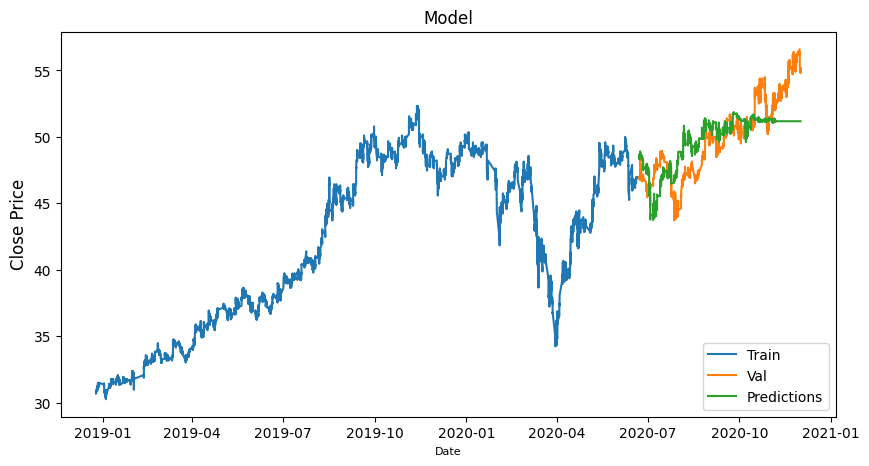

In [22]:
comparison_FPT = predict_and_plot_XGBoost(model_XGBoost_FPT, X_test_FPT, y_test_FPT, scaler_FPT, len(X_train_FPT), df_FPT)

In [23]:
comparison_FPT 

,Ticker,Open,High,Low,Close,Volume,Open Interest,Predictions
Date/Time,,,,,,,,
2020-06-22 09:46:00,FPT,46.90,46.95,46.9,46.90,1710,0,48.653275
2020-06-22 09:47:00,FPT,46.90,46.95,46.9,46.95,1080,0,48.652760
2020-06-22 09:48:00,FPT,46.95,46.95,46.9,46.95,840,0,48.654179
2020-06-22 09:49:00,FPT,46.95,46.95,46.9,46.90,900,0,48.616486
2020-06-22 09:50:00,FPT,46.90,46.95,46.9,46.95,6600,0,48.606464
...,...,...,...,...,...,...,...,...
2020-12-01 09:40:00,FPT,55.10,55.10,55.1,55.10,26820,0,51.178761
2020-12-01 09:41:00,FPT,55.00,55.00,55.0,55.00,129080,0,51.178761
2020-12-01 09:42:00,FPT,55.10,55.10,55.1,55.10,4210,0,51.178761
